# Authorship

In [2]:
import re
import os
import glob
import html
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

import seaborn as sb
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import output_file
from bokeh.palettes import Accent, Dark2
output_notebook()

Loading BokehJS ...

In [3]:
LACUNA = re.compile(r'\.\.+')

def load_file(path):
    with open(path) as f:
        xml_text = f.read()
    
    xml_text = xml_text.replace('&oudpond;', '')
    xml_text = xml_text.replace('&supm;', 'm')
    xml_text = xml_text.replace('&supM;', 'm')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&supt;', 't')
    xml_text = xml_text.replace('&supn;', 'n')
    xml_text = xml_text.replace('&sups;', 's')
    xml_text = xml_text.replace('&supd;', 'd')
    xml_text = xml_text.replace('&supc;', 'c')
    xml_text = xml_text.replace('&uring;', 'u')
    xml_text = xml_text.replace('&lt;', '')
    xml_text = xml_text.replace('&gt;', '')
    xml_text = html.unescape(xml_text)

    soup = BeautifulSoup(xml_text)
    
    data = {}

    # extract metadata:
    data['id'] = os.path.basename(path).replace('.xml', '')
    data['title'] = soup.find('title').text
    data['author'] = soup.find('author').text
    
    postquem = '<UNK>'
    try:
        postquem = soup.find('interpgrp', {'type': 'witnessYear_from'})
        postquem = postquem.find('interp')['value']
    except AttributeError:
        pass
    
    antequem = '<UNK>'
    try:
        antequem = soup.find('interpgrp', {'type': 'witnessYear_to'})
        antequem = antequem.find('interp')['value']
    except AttributeError:
        pass
    
    data['date'] = f'{postquem}-{antequem}'
    
    provenance = '<UNK>'
    try:
        provenance = soup.find('interpgrp', {'type': 'corpusProvenance'})
        provenance = provenance.find('interp')['value']
    except AttributeError:
        pass
    data['provenance'] = provenance
    
    # extract and clean lines:
    lines = []
    for line in soup.find_all('l'):
        text = line.get_text().strip()
        if text and not re.search(LACUNA, text):
            line = ''.join([c for c in text if c.isalpha() or c.isspace()]).strip()
            if line:
                lines.append(line)
    
    data['size'] = len(lines)
    data['lines'] = '\n'.join(lines)
    
    return data

In [4]:
texts = []
for fn in tqdm(glob.glob('../data/texts/rijm/*.xml')):
    texts.append(load_file(fn))

100%|██████████| 262/262 [00:33<00:00,  7.74it/s]


In [5]:
for fn in tqdm(glob.glob('../data/texts/gysseling_lit/*.xml')):
    with open(fn) as f:
        text = f.read()
    
    # metadata
    data = {}
    data['id'] = os.path.basename(fn).replace('.xml', '')
    data['title'] = re.findall(r'\<bron_oms\>(.*)\<\/bron_oms\>', text)[0]
    postquem = re.findall(r"jaar\_tot\=\'([0-9]+)'", text)[0]
    antequem = re.findall(r"jaar\_van\=\'([0-9]+)'", text)[0]
    data['date'] = f'{postquem}-{antequem}'
    
    data['provenance'] = 'Gyss.'
    data['author'] = '<UNK>'
    
    lines = []
    for line in text.split('\n'):
        line = line.strip()
        if not line:
            continue
        line = line.replace('<A >', '').replace('</A>', '')
        if not line or re.search(LACUNA, line):
            continue
        
        clean = ''
        for word in re.findall(r'<C ([0-9#\*@\+]+)_([^>]+)>\s*([^ \n\t\r<]+)', line):
            word = word[-1]
            word = ''.join([c for c in word if c.isalpha() or c.isspace()]).strip()
            if word:
                clean += word + ' '
        clean = clean.strip()
        if clean:
            lines.append(clean)
    
    data['size'] = len(lines)
    data['lines'] = '\n'.join(lines)
    
    texts.append(data)

100%|██████████| 21/21 [00:01<00:00, 20.42it/s]


In [6]:
metadata, lines = [], []
for text in texts:
    lines.append(text['lines'])
    d = {d:text[d] for d in text if d != 'lines'}
    metadata.append(d)

In [7]:
def extract_tlp(fn):
    """Extract tag-lemma pairs"""
    with open(fn) as f:
        lines = f.readlines()[1:] # ignore header

    tlps, tlp = [], []
    for line in lines:
        line = line.strip()
        if not line and tlp:
            tlps.append(tlp)
            tlp = []
        else:
            comps = line.split()
            if len(comps) == 3:
                _, lem, pos = comps
                for l, p in zip(lem.split('+'), pos.split('+')):
                    tlp.append(l + '_' + p)
    if tlp:
        tlps.append(tlp)
    
    return tlps

In [62]:
texts = []
for text in tqdm(metadata):
    texts.append(extract_tlp(f'../data/texts/rich/{text["id"]}.tsv'))

100%|██████████| 283/283 [00:08<00:00, 32.67it/s]


In [61]:
#flat_texts = [sum(text, []) for text in texts]

# rhymes
#flat_texts = []
#for text in texts:
#    flat_texts.append([l[-1] for l in text])

#print(flat_texts[0])

KeyboardInterrupt: 

In [63]:
flat_texts = []
for text in tqdm(texts):
    all_ = []
    for line in text:
        all_.extend(line)
    flat_texts.append(all_)

#print(flat_texts[0])

100%|██████████| 283/283 [00:00<00:00, 2073.70it/s]


In [64]:
from collections import Counter

In [65]:
cnt = Counter([t['author'] for t in metadata])
cnt.most_common()

[('Onbekend', 177),
 ('<UNK>', 21),
 ('Lodewijk van Velthem', 16),
 ('Jacob van Maerlant', 15),
 ('Niet van toepassing', 10),
 ('Philip Utenbroeke', 8),
 ('Jan van Boendale', 6),
 ('Jacob van Maerlant(?)', 3),
 ('Augustijnken', 3),
 ('Hein van Aken', 2),
 ('Jan de Weert', 2),
 ('Hadewijch', 2),
 ('Lambertus Goetman', 1),
 ('Calfstaf en Noydekin(?)', 1),
 ('Loy Latewaert', 1),
 ('Heinriic', 1),
 ('Heraut Beyeren', 1),
 ('Clays van Haerlem', 1),
 ('Diederic van Assenede', 1),
 ('Gielijs van Molhem', 1),
 ('Melis Stoke', 1),
 ('Jacob van Maerlant?', 1),
 ('Jan van Heelu', 1),
 ('Jan Praet', 1),
 ('Willem van Hildegaersberch', 1),
 ('Hein van Aken(?)', 1),
 ('Penninc en Pieter Vostaert', 1),
 ('Hendrik van Veldeke', 1),
 ('Dirc Potter', 1),
 ('Willem', 1)]

In [88]:
incl = ['van_den_vos_reynaerde', 'alexanders_geesten', 'reinaerts_historie',
        'roman_van_limborch', 'rose', 'roman_van_cassamus__kort_1350']

texts_, meta_ = [], []
size = 5000

def segment_text(tokens, size):
    segments = []
    si, ei = 0, size
    while ei <= len(tokens):
        segments.append(tokens[si : ei])
        si += size
        ei += size
    return segments

for meta, text in zip(metadata, flat_texts):
    if meta['id'] in incl:
        segments = segment_text(text, size)
        for segment in segments:
            texts_.append(segment)
            meta_.append(meta)

In [89]:
print(len(texts_))
print(len(meta_))

70
70


In [90]:
def identity(x):
    return x

vectorizer = TfidfVectorizer(max_features=30, analyzer=identity, min_df=.5, use_idf=False)
X = vectorizer.fit_transform(texts_).toarray()
print(X.shape)

(70, 30)


In [91]:
from scipy.spatial.distance import pdist, squareform
dm = pdist(X, metric='cosine')
dm = squareform(dm)
print(dm.shape)

(70, 70)


In [92]:
labels = [t['title'] for t in meta_]
labels

['Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Roman van Limborch',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Rose',
 'Roman van Cassamus (verkorte versie)',
 'Roman van Cassamus (verkorte versie)',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alexanders geesten',
 'Alex

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/seaborn/matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 1152x1440 with 0 Axes>

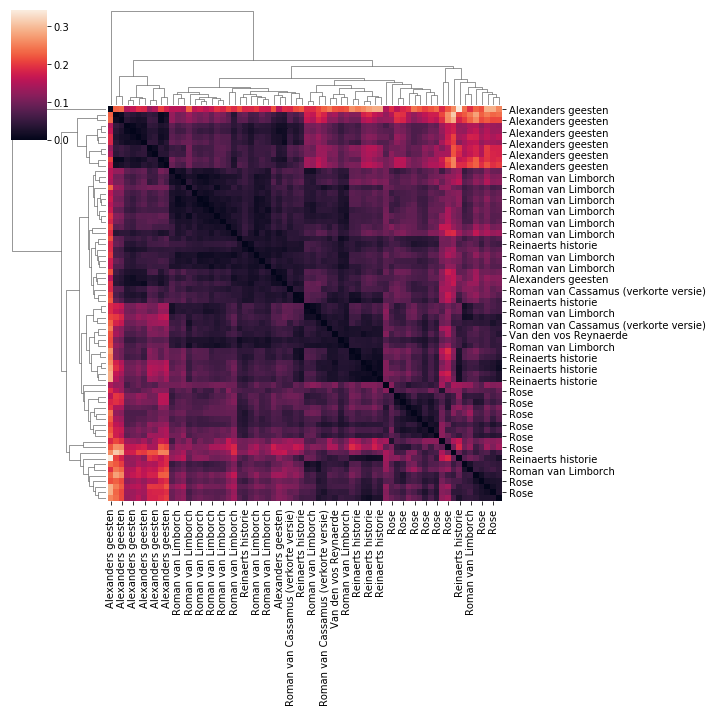

In [93]:
from seaborn import clustermap
import pandas as pd
plt.figure(figsize=(16, 20))
df = pd.DataFrame(dm, index=labels, columns=labels)
clustermap(df);